# NLP from scratch: Generating Names with a Character-Level RNN

# Preparing the Data

In [3]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != "classifying_name_with_a_character.ipynb"
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Building the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles("..\\..\\data\\name_classifying\\names\\*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError("Data not found. Make sure that you downloaded data")

print("# categories: ", n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))



# categories:  18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# Creating the Network

- Mạng RNN mở rộng bổ sung tenxo phạm trù, được nối với tenxo khác. Tenxo phạm trì là một vector one-hot giống như đầu vào chữ cái. Chúng sẽ diễn giải đầu ra là xác suất của chữ cái tiếp theo. Khi lấy mẫu, chữ cái đầu có khả năng xuất hiện nhất sẽ đuọc sử dụng để làm chữ cái đầu vào tiếp theo

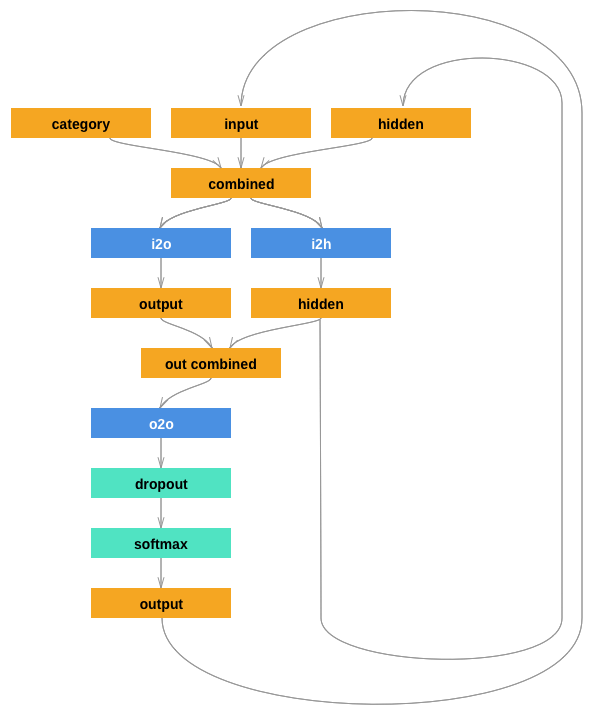

In [25]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training

In [18]:
# Prepare for training
import random

# random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

# get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

- Đối với mỗi vòng lặp (nghĩa là mỗi ký tự trong một từ huấn luyện), đầu vào của mạng sẽ là (category, curent letter, hidden state) và đầu ra là (next_letter, next hidden state)

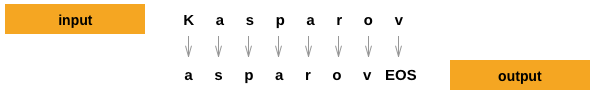

- category tensor là một one-hot tensor với kích thước (1 * n_categories)

In [27]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [7]:
# make category, input and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the network

- Ngược lại so với các bài toán phân loại, sử dụng kết quả cuối cùng để tính toán mất mát. Thì bài toán này chúng ta sử dụng từ được dự đoán để làm đầu vào cho từ tiếp theo, do đó sai số cần phải được tính ở mỗi bước này

In [22]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [30]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [31]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 2.8642
0m 37s (10000 10%) 2.6317
0m 56s (15000 15%) 2.4898
1m 12s (20000 20%) 2.5919
1m 30s (25000 25%) 2.8658
1m 49s (30000 30%) 3.6997
2m 5s (35000 35%) 2.0556
2m 22s (40000 40%) 2.5118
2m 43s (45000 45%) 2.3735
3m 4s (50000 50%) 2.3980
3m 29s (55000 55%) 2.1047
3m 50s (60000 60%) 2.3380
4m 15s (65000 65%) 2.9392
4m 42s (70000 70%) 2.7366
5m 5s (75000 75%) 2.6608
5m 28s (80000 80%) 2.5182
5m 54s (85000 85%) 1.5001
6m 16s (90000 90%) 2.5901
6m 40s (95000 95%) 2.0845
6m 59s (100000 100%) 2.8009


# Plot the Losses

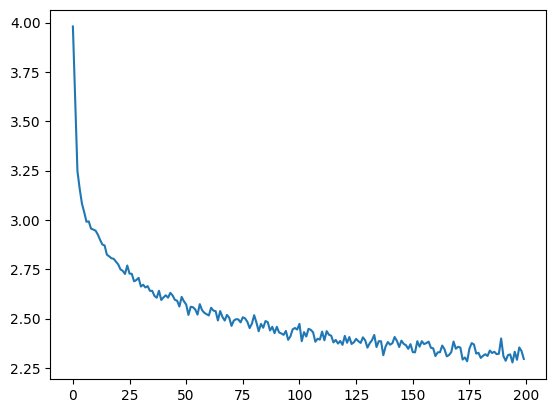

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

# Sampling the Network

- Để ví dụ thực nghiệm, chúng ta cung cấp cho mạng một chữ cái và hỏi chữ cái tiếp theo là gì, đưa chữ cái đó vào làm chữ cái tiếp theo và lặp lại cho đến khi có mã thông báo EOS.

In [33]:
max_length = 20
# sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name
    
# get multiple sampes from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


sample('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Gerter
Eringer
Rone
Salla
Para
Allan
Chan
Hin
Iun
